# MW-M31 Post-Merger Remnant: masses and densities

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Shape" data-toc-modified-id="Shape-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Shape</a></span></li><li><span><a href="#Mass-profiles" data-toc-modified-id="Mass-profiles-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Mass profiles</a></span><ul class="toc-item"><li><span><a href="#Hernquist-fits" data-toc-modified-id="Hernquist-fits-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Hernquist fits</a></span></li><li><span><a href="#Sersic-fits" data-toc-modified-id="Sersic-fits-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Sersic fits</a></span></li></ul></li><li><span><a href="#Densities" data-toc-modified-id="Densities-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Densities</a></span></li><li><span><a href="#Virial-radius/mass" data-toc-modified-id="Virial-radius/mass-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Virial radius/mass</a></span></li></ul></div>

## Setup

In [114]:
# import modules
import numpy as np
import numpy.linalg as la
from numpy.linalg import norm, eigh
from scipy.optimize import curve_fit
import pandas as pd
import astropy.units as u
from astropy.constants import G
from astropy.cosmology import Planck15, z_at_value

# import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mpl_scatter_density
from matplotlib import rcParams
from matplotlib.patches import Ellipse
# 
# Make the norm object to define the image stretch
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
im_norm = ImageNormalize(vmin=0., vmax=1000, stretch=LogStretch())

%matplotlib inline

In [67]:
# my modules
from galaxy.galaxy import Galaxy
from galaxy.centerofmass import CenterOfMass
from galaxy.massprofile import MassProfile
from galaxy.plots import Plots
from galaxy.timecourse import TimeCourse
from galaxy.utilities import find_nearest, rotation_matrix_to_vector, z_rotation_matrix

from galaxy.remnant import Remnant

In [85]:
tc = TimeCourse()
p = Plots()

In [9]:
# Just luminous particles: ptype defaults to (2,3)
remnant = Remnant(usesql=True)

In [10]:
remnant.data, remnant.data.shape

(array([('M31', 2, 2.000e-05, 196.939, 24.1967, 139.881, 260.831  ,  -85.0969, -26.0921),
        ('M31', 2, 2.000e-05, 189.087, 20.2326, 146.165,  18.4025 ,   23.0247,  32.5107),
        ('M31', 2, 2.000e-05, 206.619, 19.0085, 122.444, -62.8166 , -162.355 , 181.913 ),
        ...,
        ('MW ', 3, 2.001e-05, 171.059, 13.8007, 128.251,  42.7172 ,  -34.8959,  64.3355),
        ('MW ', 3, 2.001e-05, 188.957, 23.4792, 147.111, 257.351  ,  -53.4361, -95.3574),
        ('MW ', 3, 2.001e-05, 189.534, 21.7683, 148.253,  -2.96004,   82.9176,  26.7174)],
       dtype=[('galname', '<U3'), ('type', 'u1'), ('m', '<f4'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('vx', '<f4'), ('vy', '<f4'), ('vz', '<f4')]),
 (1120000,))

In [11]:
def get_counts(remnant):
    df = pd.DataFrame()
    df['gal'] = remnant.data['galname']
    df['type'] = remnant.data['type']

    # create some better column names
    types = {1: 'Halo', 2: 'Disk', 3: 'Bulge'}
    df['typename'] = df['type'].map(types)

    # get pandas to do most of the work
    df_piv = pd.pivot_table(df, values='type',
                            index='gal', columns='typename',
                            aggfunc='count', fill_value=0, margins=True)
    return df_piv

In [12]:
counts = get_counts(remnant) / 1000
counts

typename,Bulge,Disk,All
gal,,,
M31,95.0,600.0,695.0
MW,50.0,375.0,425.0
All,145.0,975.0,1120.0


In [13]:
print(counts.to_latex())

\begin{tabular}{lrrr}
\toprule
typename &  Bulge &   Disk &     All \\
gal &        &        &         \\
\midrule
M31 &   95.0 &  600.0 &   695.0 \\
MW  &   50.0 &  375.0 &   425.0 \\
All &  145.0 &  975.0 &  1120.0 \\
\bottomrule
\end{tabular}



## Shape

Get remnant-centered coordinates: just translation, no rotation at this stage

In [14]:
com = CenterOfMass(remnant, ptype=None)

In [15]:
xyz, vxyz = com.center_com()

In [16]:
xyz.shape

(3, 1120000)

Define some methods to calculate principal axes of the (presumed) ellipsoid:

In [37]:
def get_where(gal, ptype):
    if gal == 'MW':
        gal = 'MW ' # annoying!
    return np.where((remnant.data['galname']==gal) & (remnant.data['type']==ptype))

def sub_ellipsoid_axes(subset, r_lim=None):
    x,y,z = (xyz.T[subset]).T
    m = remnant.data[subset]['m']

    return remnant.ellipsoid_axes(m, x, y, z, r_lim)

Subset the data by origin, galaxy/particle type:

In [38]:
MWh = get_where('MW', 1)
MWd = get_where('MW', 2)
MWb = get_where('MW', 3)
M31h = get_where('M31', 1)
M31d = get_where('M31', 2)
M31b = get_where('M31', 3)

In [55]:
x,y,z = xyz
m = remnant.data['m']
abc = {}
axes = {}

Get inertia tensor and eigenvalues

In [64]:
r_lim = 40
r = norm(xyz, axis=0)
central = np.where(r < r_lim)
m_c = m[central]
x_c = x[central]
y_c = y[central]
z_c = z[central]
xyz_c = np.array([x_c, y_c, z_c])
I = remnant.I_tensor(m_c, x_c, y_c, z_c)
w, v = eigh(I)

# moments of intertia around principal axes:
A, B, C = w / np.max(w)
A, B, C

(0.7961196, 0.8494761, 1.0)

In [71]:
min_axis = I[0]/norm(I[0])
mid_axis = I[1]/norm(I[1])
maj_axis = I[2]/norm(I[2])
min_axis, mid_axis, maj_axis

(array([0.99737144, 0.05540401, 0.04669665], dtype=float32),
 array([0.06093079, 0.99706465, 0.04636314], dtype=float32),
 array([0.05441254, 0.04912363, 0.99730945], dtype=float32))

In [66]:
xyz_c.shape, xyz_c.shape[1]/xyz.shape[1]

((3, 982164), 0.8769321428571428)

In [69]:
R = rotation_matrix_to_vector(maj_axis)
R

array([[ 0.99851767, -0.00133824, -0.05441254],
       [-0.00133824,  0.99879183, -0.04912364],
       [ 0.05441254,  0.04912364,  0.99730951]])

In [78]:
x_r, y_r, z_r = R @ xyz_c

In [79]:
R @ min_axis, R @ mid_axis

(array([0.99327798, 0.05170843, 0.10356217]),
 array([0.05698342, 0.99350096, 0.09853324]))

In [80]:
np.arccos(np.dot(R @ min_axis, np.array([1,0,0]))) * 180/np.pi

6.6470844403732

/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/mpl_scatter_density/generic_density_artist.py:74: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/mpl_scatter_density/generic_density_artist.py:79: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


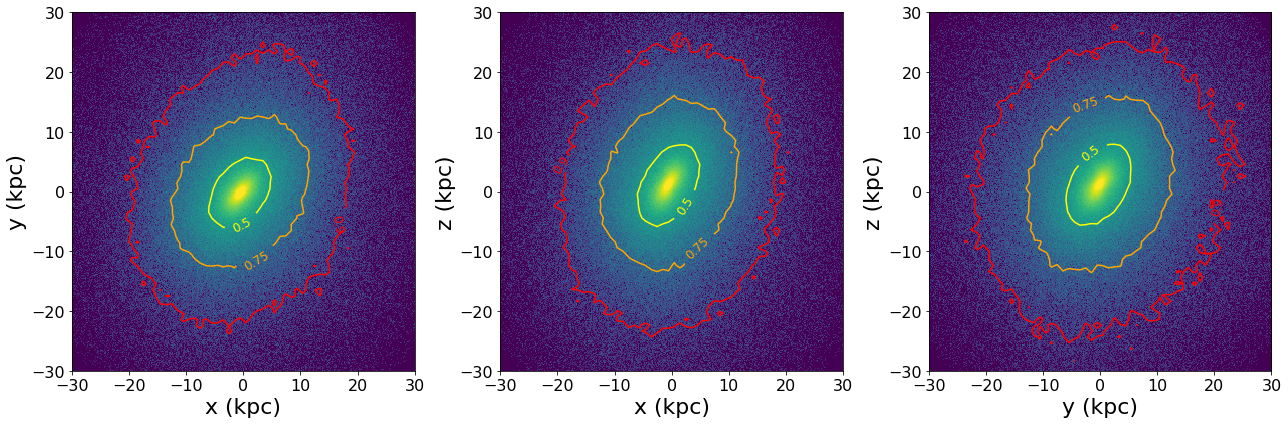

In [92]:
fig = plt.figure(figsize=(18,6))
lim = 30
fontsize = 22 # for labels

# left plot x-y
ax0 = fig.add_subplot(1, 3, 1, projection='scatter_density')
ax0.scatter_density(x_r, y_r, norm=im_norm)

ax0.set_xlim(-lim, lim)
ax0.set_ylim(-lim, lim)

ax0.set_xlabel('x (kpc)', fontsize=fontsize)
ax0.set_ylabel('y (kpc)', fontsize=fontsize)

level_vals = [0.5, 0.75, 0.9]
colors = ['red','orange', 'yellow', 'orange', 'yellow']

p.density_contour(x_r, y_r, 80, 80, level_vals, ax=ax0, colors=colors)

# mid plot x-z
ax1 = fig.add_subplot(1, 3, 2, projection='scatter_density')
ax1.scatter_density(x_r, z_r, norm=im_norm)

ax1.set_xlim(-lim, lim)
ax1.set_ylim(-lim, lim)

ax1.set_xlabel('x (kpc)', fontsize=fontsize)
ax1.set_ylabel('z (kpc)', fontsize=fontsize)

c = p.density_contour(x_r, z_r, 80, 80, level_vals, ax=ax1, colors=colors)

# right plot y-z
ax2 = fig.add_subplot(1, 3, 3, projection='scatter_density')
ax2.scatter_density(y_r, z_r, norm=im_norm)

ax2.set_xlim(-lim, lim)
ax2.set_ylim(-lim, lim)

ax2.set_xlabel('y (kpc)', fontsize=fontsize)
ax2.set_ylabel('z (kpc)', fontsize=fontsize);

p.density_contour(y_r, z_r, 80, 80, level_vals, ax=ax2, colors=colors)

#adjust tick label font size
label_size = 16
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size
plt.tight_layout()
plt.savefig('remnant_shape_tensor.pdf', rasterized=True, dpi=350);

In [104]:
segs = c.allsegs
len(segs), len(segs[2]), len(segs[2][0])

(3, 1, 51)

In [130]:
(segs[2][0].T[0].min() + segs[2][0].T[0].max())/2

-0.5426564827475051

In [131]:
(segs[2][0].T[1].min() + segs[2][0].T[1].max())/2

0.9905707852586021

In [134]:
np.mean(segs[2][0].T[0]), np.mean(segs[2][0].T[1])

(-0.6021915245957675, 0.9586809035015407)

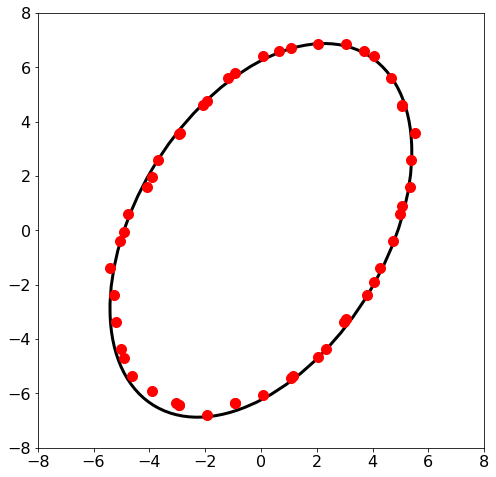

In [158]:
lim=8
fig, ax = plt.subplots(figsize=(8,8))
x = segs[2][0].T[0] - np.mean(segs[2][0].T[0])
y = segs[2][0].T[1] - np.mean(segs[2][0].T[1])
ax.plot(x, y, 'r.', ms=20)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.add_artist(Ellipse((0,0), 15, 9, 60, fill=False, lw=3));

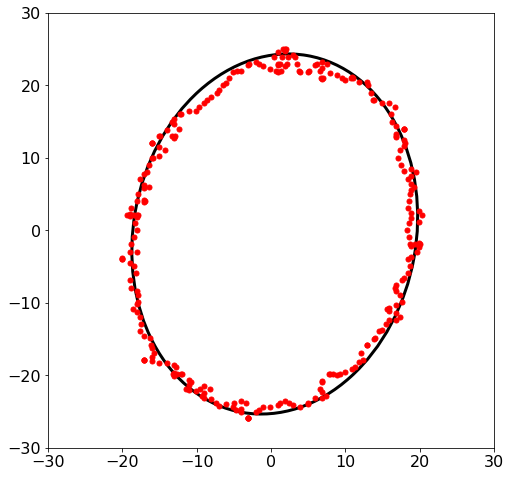

In [161]:
lim=30
fig, ax = plt.subplots(figsize=(8,8))
x = segs[0][0].T[0] - np.mean(segs[0][0].T[0])
y = segs[0][0].T[1] - np.mean(segs[0][0].T[1])
ax.plot(x, y, 'r.', ms=10)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.add_artist(Ellipse((0.5,-0.5), 50, 38, 80, fill=False, lw=3));

Repeat on subgroups:

In [44]:
abc['total'], axes['total'] = remnant.ellipsoid_axes(m, x, y, z, r_lim)

abc['MWd'], axes['MWd'] = sub_ellipsoid_axes(MWd, r_lim)
abc['MWb'], axes['MWb'] = sub_ellipsoid_axes(MWb, r_lim)
abc['M31d'], axes['M31d'] = sub_ellipsoid_axes(M31d, r_lim)
abc['M31b'], axes['M31b'] = sub_ellipsoid_axes(M31b, r_lim)
abc, axes

({'total': (1.0, 0.9479938644421531, 0.7828753318149164),
  'MWd': (1.0, 0.9542774072707867, 0.6417756565556153),
  'MWb': (1.0, 0.9618611396181502, 0.7053421749714935),
  'M31d': (1.0, 0.9073498934576228, 0.817813215305859),
  'M31b': (1.0, 0.9511929595817055, 0.8269979084026381)},
 {'total': (array([-0.1141199, -0.4164999,  0.9019448], dtype=float32),
   array([-0.5236497 ,  0.7967378 ,  0.30166188], dtype=float32),
   array([-0.8442557 , -0.43787754, -0.3090237 ], dtype=float32)),
  'MWd': (array([-0.5435413 ,  0.11009081,  0.8321315 ], dtype=float32),
   array([ 0.24932252, -0.92544425,  0.28529143], dtype=float32),
   array([-0.8014993 , -0.3625368 , -0.47556904], dtype=float32)),
  'MWb': (array([ 0.48961687,  0.15723707, -0.8576432 ], dtype=float32),
   array([ 0.51378435, -0.8467354 ,  0.13807523], dtype=float32),
   array([-0.7044863, -0.5082476, -0.4953619], dtype=float32)),
  'M31d': (array([ 0.12519786, -0.42074367,  0.8984989 ], dtype=float32),
   array([-0.3927667 ,  0.81

Use pandas to organize and output the results:

In [45]:
df = pd.DataFrame()

df['set'] = np.array([k for k, _ in abc.items()])
df['a'] = np.array([np.round(v[0], 2) for _, v in abc.items()])
df['b'] = np.array([np.round(v[1], 2) for _, v in abc.items()])
df['c'] = np.array([np.round(v[2], 2) for _, v in abc.items()])
df

,set,a,b,c
0,total,1.0,0.95,0.78
1,MWd,1.0,0.95,0.64
2,MWb,1.0,0.96,0.71
3,M31d,1.0,0.91,0.82
4,M31b,1.0,0.95,0.83


In [46]:
print(df.to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
   set &    a &     b &     c \\
\midrule
 total &  1.0 &  0.95 &  0.78 \\
   MWd &  1.0 &  0.95 &  0.64 \\
   MWb &  1.0 &  0.96 &  0.71 \\
  M31d &  1.0 &  0.91 &  0.82 \\
  M31b &  1.0 &  0.95 &  0.83 \\
\bottomrule
\end{tabular}



What is the relative orientation of component ellipsoids?

In [47]:
def tilt_angle(group1, group2):
    # these should already be unit vectors, but normalise for safety
    vec1 = axes[group1][0]/la.norm(axes[group1][0])
    vec2 = axes[group2][0]/la.norm(axes[group2][0])
    dot = np.dot(vec1, vec2)
    return np.round(np.arccos(np.abs(dot)) * 180 / np.pi, 1)        

In [48]:
groups = [k for k,_ in abc.items()]
tilts = pd.DataFrame([[tilt_angle(g1, g2) for g1 in groups] for g2 in groups], columns=groups)
print(groups)
tilts

['total', 'MWd', 'MWb', 'M31d', 'M31b']


/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in arccos
  


,total,MWd,MWb,M31d,M31b
0,0.0,39.9,26.5,13.7,21.6
1,39.9,0.0,15.7,50.7,19.9
2,26.5,15.7,0.0,39.2,4.9
3,13.7,50.7,39.2,0.0,34.4
4,21.6,19.9,4.9,34.4,NaN


In [49]:
print(tilts.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  total &   MWd &   MWb &  M31d &  M31b \\
\midrule
0 &    0.0 &  39.9 &  26.5 &  13.7 &  21.6 \\
1 &   39.9 &   0.0 &  15.7 &  50.7 &  19.9 \\
2 &   26.5 &  15.7 &   0.0 &  39.2 &   4.9 \\
3 &   13.7 &  50.7 &  39.2 &   0.0 &  34.4 \\
4 &   21.6 &  19.9 &   4.9 &  34.4 &   NaN \\
\bottomrule
\end{tabular}



## Mass profiles

Work here with all particles, both baryonic and DM:

In [20]:
snap = 801
full_remnant = Remnant(snap=snap, usesql=True, ptype=(1,2,3))
mp = MassProfile(full_remnant)
t = tc.snap2time(snap)

In [21]:
counts = get_counts(full_remnant) / 1000
counts

typename,Bulge,Disk,Halo,All
gal,,,,
M31,95.0,600.0,250.0,945.0
MW,50.0,375.0,250.0,675.0
All,145.0,975.0,500.0,1620.0


Fit the Hernquist profile for DM particles of all origins:

In [22]:
fitted_a, err = mp.fit_hernquist_a(get_details=True)
fitted_a, err

(<Quantity 84.5 kpc>, <Quantity 0.5 kpc>)

Define some radii, then plot:

In [23]:
radii = np.linspace(0.1, 100) * u.kpc

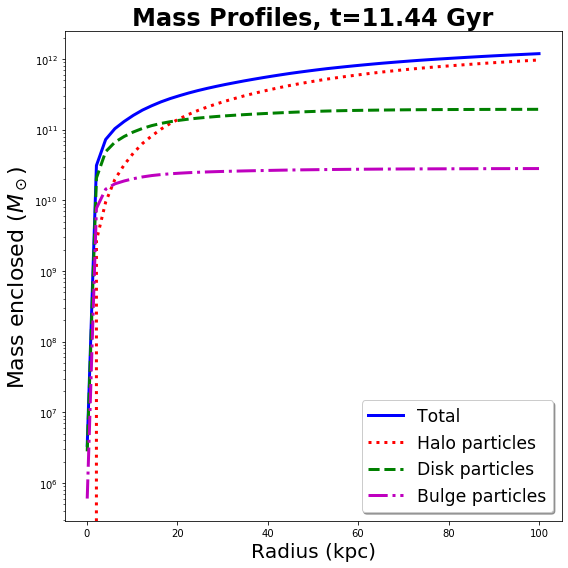

In [24]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot()

# add the curves
ax.semilogy(radii, mp.mass_enclosed_total(radii), 'b-', lw=3, 
            label='Total')
ax.semilogy(radii, mp.mass_enclosed(radii, 1), 'r:', lw=3, 
            label='Halo particles')
ax.semilogy(radii, mp.mass_enclosed(radii, 2), 'g--', lw=3, 
            label='Disk particles')
ax.semilogy(radii, mp.mass_enclosed(radii, 3), 'm-.', lw=3, 
            label='Bulge particles')

#adjust tick label font size
label_size = 16
rcParams['xtick.labelsize'] = label_size 
rcParams['ytick.labelsize'] = label_size

# Add labels and subplot title
ax.set_xlabel('Radius (kpc)', fontsize=20)
ax.set_ylabel(r'Mass enclosed ($M_\odot$)', fontsize=22)
ax.legend(loc='lower right',fontsize='xx-large', shadow=True)

#set axis limits
# ax.set_ylim(ylim[0], ylim[1])

# Overall title
ax.set_title(f'Mass Profiles, t={t:.2f} Gyr', y=1.0, 
            fontsize=24, weight='bold')
plt.tight_layout()
plt.savefig('remnant_mp_types.pdf', rasterized=True, dpi=350);

In [25]:
def sub_coords(m, xyz, subset):
    xyz = (xyz.T[subset]).T
    m = m[subset]

    return m, xyz

In [26]:
m = full_remnant.data['m']

com = CenterOfMass(full_remnant, ptype=None)
xyz, vxyz = com.center_com()
xyz.shape

(3, 1620000)

In [27]:
def get_full_where(gal, ptype):
    if gal == 'MW':
        gal = 'MW ' # annoying!
    return np.where((full_remnant.data['galname']==gal) & (full_remnant.data['type']==ptype))

Subset the data by origin, galaxy/particle type:

In [28]:
MWh = get_full_where('MW', 1)
MWd = get_full_where('MW', 2)
MWb = get_full_where('MW', 3)
M31h = get_full_where('M31', 1)
M31d = get_full_where('M31', 2)
M31b = get_full_where('M31', 3)

m_MWd, xyz_MWd = sub_coords(m, xyz, MWd)
m_MWh, xyz_MWh = sub_coords(m, xyz, MWh)
m_MWb, xyz_MWb = sub_coords(m, xyz, MWb)
m_M31d, xyz_M31d = sub_coords(m, xyz, M31d)
m_M31h, xyz_M31h = sub_coords(m, xyz, M31h)
m_M31b, xyz_M31b = sub_coords(m, xyz, M31b)

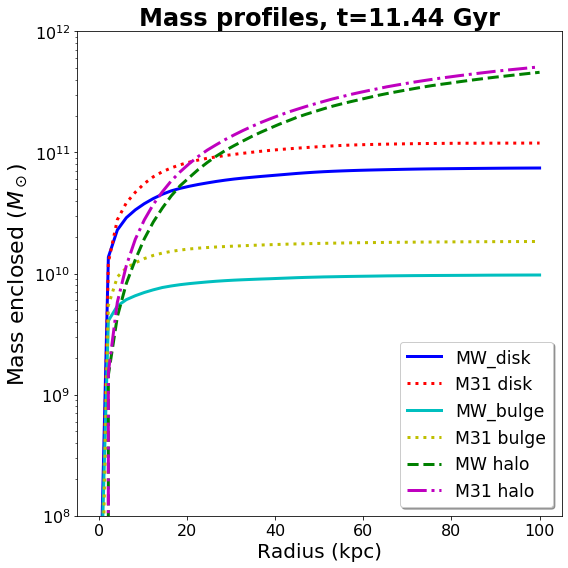

In [29]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot()

# data
radii = np.linspace(0.1, 100) * u.kpc

# add the curves
ax.semilogy(radii, full_remnant.sub_mass_enclosed(radii, m_MWd, xyz_MWd), 'b-',
             lw=3, label='MW_disk')
ax.semilogy(radii, full_remnant.sub_mass_enclosed(radii, m_M31d, xyz_M31d), 'r:',
             lw=3, label='M31 disk')
ax.semilogy(radii, full_remnant.sub_mass_enclosed(radii, m_MWb, xyz_MWb), 'c-', 
             lw=3, label='MW_bulge')
ax.semilogy(radii, full_remnant.sub_mass_enclosed(radii, m_M31b, xyz_M31b), 'y:',
             lw=3, label='M31 bulge')
ax.semilogy(radii, full_remnant.sub_mass_enclosed(radii, m_MWh, xyz_MWh), 'g--',
             lw=3, label='MW halo')
ax.semilogy(radii, full_remnant.sub_mass_enclosed(radii, m_M31h, xyz_M31h), 'm-.',
             lw=3, label='M31 halo')

#adjust tick label font size
label_size = 16
rcParams['xtick.labelsize'] = label_size 
rcParams['ytick.labelsize'] = label_size

# Add labels and subplot title
ax.set_xlabel('Radius (kpc)', fontsize=20)
ax.set_ylabel(r'Mass enclosed ($M_\odot$)', fontsize=22)
ax.legend(loc='lower right',fontsize='xx-large', shadow=True)

#set axis limits
ax.set_ylim(1e8, 1e12)

# Overall title
ax.set_title(f'Mass profiles, t={t:.2f} Gyr', y=1.0, 
            fontsize=24, weight='bold')
plt.tight_layout()
plt.savefig('remnant_mp_origins.pdf', rasterized=True, dpi=350);

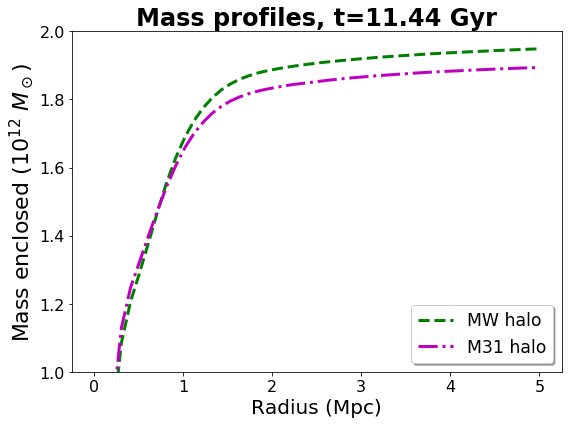

In [30]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot()

# data
radii5M = np.linspace(5, 5000) * u.kpc

# add the curves
ax.plot(radii5M/1e3, full_remnant.sub_mass_enclosed(radii5M, m_MWh, xyz_MWh)/1e12, 
             'g--', lw=3, label='MW halo')
ax.plot(radii5M/1e3, full_remnant.sub_mass_enclosed(radii5M, m_M31h, xyz_M31h)/1e12,
              'm-.', lw=3, label='M31 halo')

#adjust tick label font size
label_size = 16
rcParams['xtick.labelsize'] = label_size 
rcParams['ytick.labelsize'] = label_size

# Add labels and subplot title
ax.set_xlabel('Radius (Mpc)', fontsize=20)
ax.set_ylabel(r'Mass enclosed ($10^{12}\ M_\odot$)', fontsize=22)
ax.legend(loc='lower right',fontsize='xx-large', shadow=True)

#set axis limits
ax.set_ylim(1, 2)

# Overall title
ax.set_title(f'Mass profiles, t={t:.2f} Gyr', y=1.0, 
            fontsize=24, weight='bold')
plt.tight_layout()
plt.savefig('remnant_mp_halo.pdf', rasterized=True, dpi=350);

### Hernquist fits

In [31]:
hnames = ['MW halo','M31 halo']
hprofiles = [(m_MWh, xyz_MWh), (m_M31h, xyz_M31h)]

In [32]:
print("Hernquist fits for remnant subsets\n")
for i, (m, xyz) in enumerate(hprofiles):
    n, err = full_remnant.fit_hernquist_a(m, xyz)
    print(f"{hnames[i]:>4} n = {n:5.2f} +/- {err:.2f}")

Hernquist fits for remnant subsets

MW halo n = 95.19 kpc +/- 1.36 kpc
M31 halo n = 82.30 kpc +/- 0.89 kpc


### Sersic fits

In [33]:
def sersic_data(radii, m, xyz):
    sub_Re, sub_total, subI = full_remnant.Re(radii, m, xyz)
    n, err = full_remnant.fit_sersic_n(radii, sub_Re, sub_total, subI)
    Sersic = full_remnant.sersic(radii.value, sub_Re.value, n, sub_total)
    return sub_Re, sub_total, subI, n, err, Sersic

In [34]:
lnames = ['MW disk','M31 disk', 'MW bulge','M31 bulge']
lprofiles = [(m_MWd, xyz_MWd), (m_M31d, xyz_M31d),
           (m_MWb, xyz_MWb), (m_M31b, xyz_M31b)]

In [35]:
radii60 = np.linspace(2, 60) * u.kpc

for i, (m, xyz) in enumerate(lprofiles):
    sub_Re, sub_total, subI, n, err, Sersic = sersic_data(radii60, m, xyz)
    print(f"{lnames[i]:>4} n = {n:4.2f} +/- {err:.3f}")

MW disk n = 5.35 +/- 0.000
M31 disk n = 5.43 +/- 0.001
MW bulge n = 5.46 +/- 0.000
M31 bulge n = 5.42 +/- 0.000


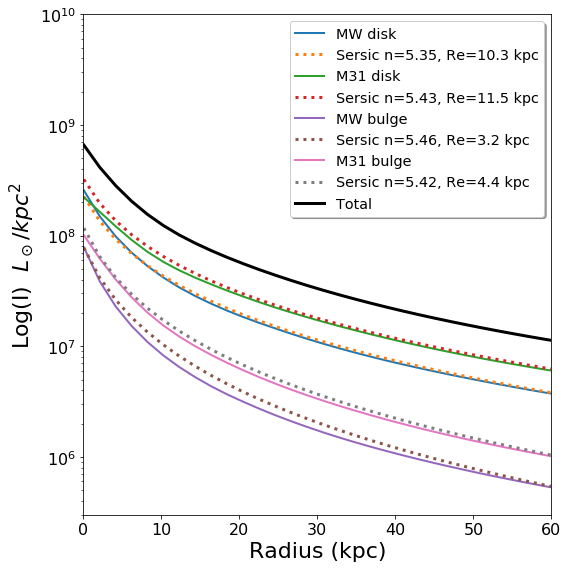

In [36]:
fig = plt.figure(figsize=(8,8))
# subplots = (121, 122)

ax0 = plt.subplot()

subIs = []

# plot the luminosity density as a proxy for surface brightness
for i, (m, xyz) in enumerate(lprofiles):
    sub_Re, sub_total, subI, n, err, Sersic = sersic_data(radii60, m, xyz)
    subIs.append(subI)
    ax0.semilogy(radii, subI, lw=2, label=f'{lnames[i]}')
    ax0.semilogy(radii, Sersic, lw=3, ls=':',
                     label=f'Sersic n={n:.2f}, Re={sub_Re:.1f}')
total_I = subIs[0]
for I in subIs[1:]:
    total_I += I
ax0.semilogy(radii, total_I, 'k-', lw=3, label='Total')

# Add axis labels
ax0.set_xlabel('Radius (kpc)', fontsize=22)
ax0.set_ylabel('Log(I)  $L_\odot/kpc^2$', fontsize=22)

ax0.set_xlim(0,60)
ax0.set_ylim(3e5, 1e10)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax0.legend(fontsize='x-large', shadow=True)
plt.tight_layout()
plt.savefig('remnant_sersic_origins.pdf', rasterized=True, dpi=350);

## Densities

In [37]:
radii100 = np.linspace(1, 100) * u.kpc
mp.density_profile(radii100, m, xyz)

(<Quantity [ 1.73793215,  3.90196396,  5.96609887,  8.00796147, 10.04114816,
            12.07004408, 14.09650206, 16.12144146, 18.14537069, 20.16859386,
            22.1913041 , 24.21362994, 26.23566029, 28.25745857, 30.27907128,
            32.30053325, 34.32187112, 36.3431056 , 38.36425302, 40.38532647,
            42.40633651, 44.4272918 , 46.44819948, 48.46906552, 50.48989491,
            52.51069188, 54.53146003, 56.55220246, 58.57292183, 60.59362045,
            62.61430031, 64.6349632 , 66.65561063, 68.67624399, 70.69686448,
            72.71747317, 74.73807101, 76.75865887, 78.77923751, 80.79980763,
            82.82036984, 84.84092472, 86.86147277, 88.88201446, 90.90255022,
            92.92308042, 94.94360544, 96.96412558, 98.98464115] kpc>,
 <Quantity [5.34402962e+07, 6.53739933e+06, 1.41645681e+06, 6.36459287e+05,
            3.66592825e+05, 2.01859643e+05, 1.09249766e+05, 6.72682430e+04,
            4.23492784e+04, 2.81790515e+04, 1.84017414e+04, 1.21610776e+04,
         

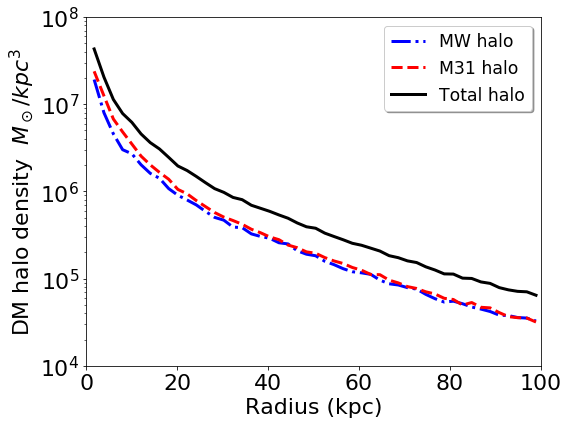

In [38]:
fig = plt.figure(figsize=(8,6))
ax0 = plt.subplot()

styles = ['b-.', 'r--', 'g:', 'y.-']

# plot the mass density 
rhos = []
for i, (m, xyz) in enumerate(hprofiles):
    r_annuli, rho = mp.density_profile(radii100, m, xyz)
    rhos.append(rho)
    ax0.semilogy(r_annuli, rho, styles[i], lw=3, label=f'{hnames[i]}')
rho_total = rhos[0] + rhos[1]
ax0.semilogy(r_annuli, rho_total, 'k-', lw=3, label='Total halo')
#     ax0.semilogy(radii, Sersic, lw=3, ls=':',
#                      label=f'Sersic n={n:.2f}, Re={sub_Re:.1f}')

# Add axis labels
ax0.set_xlabel('Radius (kpc)', fontsize=22)
ax0.set_ylabel('DM halo density  $M_\odot/kpc^3$', fontsize=22)

ax0.set_xlim(0,100)
ax0.set_ylim(1e4, 1e8)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax0.legend(fontsize='xx-large', shadow=True)
plt.tight_layout()
plt.savefig('remnant_DM_rho.pdf', rasterized=True, dpi=350);

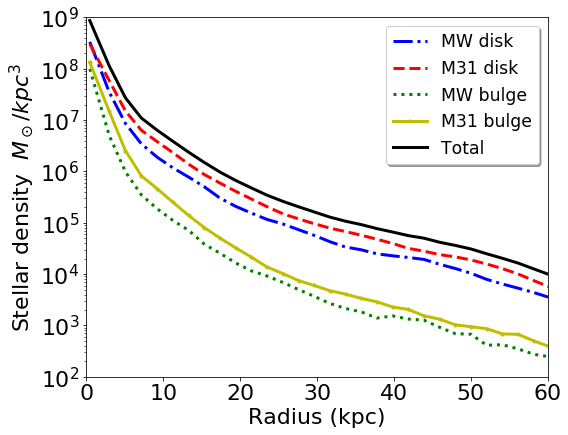

In [39]:
fig = plt.figure(figsize=(8,6))
ax0 = plt.subplot()

styles = ['b-.', 'r--', 'g:', 'y.-']

rhos = []

# plot the mass density 
for i, (m, xyz) in enumerate(lprofiles):
    r_annuli, rho = mp.density_profile(radii, m, xyz)
    rhos.append(rho)
    ax0.semilogy(r_annuli, rho, styles[i], lw=3, label=f'{lnames[i]}')

total_rho = rhos[0]
for r in rhos[1:]:
    total_rho += r
ax0.semilogy(r_annuli, total_rho, 'k-', lw=3, label='Total')

# Add axis labels
ax0.set_xlabel('Radius (kpc)', fontsize=22)
ax0.set_ylabel('Stellar density  $M_\odot/kpc^3$', fontsize=22)

ax0.set_xlim(0,60)
ax0.set_ylim(1e2, 1e9)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax0.legend(fontsize='xx-large', shadow=True)
plt.tight_layout()
plt.savefig('remnant_lum_rho.pdf', rasterized=True, dpi=350);

## Virial radius/mass

Current values:

In [40]:
Planck15.critical_density0.to(u.Msun/u.kpc**3)

<Quantity 127.35344307 solMass / kpc3>

In [41]:
H0 = Planck15.H0
H0

<Quantity 67.74 km / (Mpc s)>

In [42]:
rho_c = (3*H0**2 / (8*np.pi*G)).to(u.Msun/u.kpc**3)
rho_c

<Quantity 127.35344307 solMass / kpc3>

Limiting values, far future:

In [43]:
H_lim = 57 * u.km/u.s/u.Mpc

In [44]:
rho_lim = (3*H_lim**2 / (8*np.pi*G)).to(u.Msun/u.kpc**3)
rho_lim

<Quantity 90.17165019 solMass / kpc3>

In [45]:
200*rho_lim

<Quantity 18034.33003829 solMass / kpc3>

Find the radius r_200:

In [46]:
snap = 801
full_remnant = Remnant(snap=snap, usesql=True, ptype=(1,2,3))
mp = MassProfile(full_remnant)
t = tc.snap2time(snap)

In [47]:
r_200_0 = mp.virial_radius()
r_200_lim = mp.virial_radius(rho_c=rho_lim)
r_200_0, r_200_lim

(141.70679638255373, 169.84778923581916)

Get the enclosed virial mass:

In [48]:
vm_0 = mp.virial_mass(r_200=r_200_0)
vm_lim = mp.virial_mass(r_200=r_200_lim)
vm_0, vm_lim

(<Quantity [1.5093693e+12] solMass>, <Quantity [1.6973937e+12] solMass>)

What fraction is DM?

In [49]:
mp.mass_enclosed([r_200_0*u.kpc,], 1) / vm_0

<Quantity [0.852029]>

In [50]:
mp.mass_enclosed([r_200_lim*u.kpc,], 1) / vm_lim

<Quantity [0.8683501]>